# The data set provided by Tishby

First, we load the data set provided by Tishby.

In [26]:
import os
import sys
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
sys.path.append(nb_dir)
from deep_bottleneck.datasets import harmonics
import numpy as np

dataset = harmonics.load(nb_dir = nb_dir + '/deep_bottleneck/')

X = np.concatenate([dataset.train.examples, dataset.test.examples])
Y = np.concatenate([dataset.train.labels, dataset.test.labels])

Next, we analyze the loaded data set. In this data set, $X$ corresponds to the 12 binary inputs that represent 12 uniformly distributed points on a 2-sphere. $X$ is realized as one of the 4096 possible combinations of the 12 binary inputs. $Y$ corresponds to $\Theta\left(f\left(X\right) - \theta\right)$, where $f$ is a spherically symmetric real-valued function, $\theta$ is a threshold, $\Theta$ a step function that outputs either $0$ or $1$.

We sum over the 12 binary inputs of $X$ and determine the share of $Y=1$ per each possible sum value. 

In [27]:
X_sum_Y = []

for i in range(13):
    X_sum_Y.append([])

for i in range(len(X)):
    n_pos_inputs = np.sum(X[i])
    X_sum_Y[n_pos_inputs].append(Y[i])

print('Share of Y=1 per each value of the sum of the binary inputs of X:')
for i in range(13):
    proportion = 100 * np.sum(np.array(X_sum_Y[i]))/len(X_sum_Y[i])
    print(f'{i}: {proportion}%')

Share of Y=1 per each value of the sum of the binary inputs of X:
0: 0.0%
1: 0.0%
2: 0.0%
3: 0.0%
4: 0.0%
5: 7.575757575757576%
6: 57.57575757575758%
7: 92.42424242424242%
8: 100.0%
9: 100.0%
10: 100.0%
11: 100.0%
12: 100.0%


# Our attempt to generate the data set above

After analyzing the provided data set, we try to generate a similar one ourselves since the explicit algorithm for doing so was not provided in the paper.

The first task is to sample 12 uniformly distributed points on a unit 2-sphere. For that purpose, we randomly sample $\theta$ from $[0, 2\pi]$ using the uniform distribution. Then, we randomly sample a value for the cosine of $\phi$ from $[-1, 1]$ again using the uniform distribution. Finally, we apply arccosine to the sampled cosine of $\phi$ to get $\phi$ itself. Contrary to the convention, we have assigned $\theta$ to the aziumthal angle and $\phi$ to the polar angle to keep the naming consistent with SciPy's spherical harmonics implementation.

Alternatively, one can randomly sample a 3-dimensional vector from $\mathbb{R}^3$ using standard normal distribution, normalize it, and convert Cartesian coordinates to spherical coordinates.

In [28]:
import random
from scipy.special import sph_harm

def sample_spherical(npoints):
    """Sample npoints uniformly distributed
    points on a unit 2-sphere
    """
    thetas = np.zeros(npoints)
    phis = np.zeros(npoints)
    for i in range(npoints):
        thetas[i] = random.uniform(0, 2*np.pi)
        cos_phi = random.uniform(-1, 1)
        phis[i] = np.arccos(cos_phi)
    return thetas, phis

def alternative_sample_spherical(npoints):
    """Sample npoints uniformly distributed
    points on a unit 2-sphere
    """
    vec = np.random.randn(3, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    thetas = np.arctan2(vec[1], vec[0]) + np. pi
    phis = np.arccos(vec[2])
    return thetas, phis

def wrong_sample_spherical(npoints):
    """Sample npoints points on a unit 2-sphere
    """
    thetas = np.zeros(npoints)
    phis = np.zeros(npoints)
    for i in range(npoints):
        thetas[i] = random.uniform(0, 2*np.pi)
        phis[i] = random.uniform(0, np.pi)
    return thetas, phis

np.random.seed(2)
random.seed(0)
thetas, phis = sample_spherical(12)

Directly sampling $\phi$ from $[0, \pi]$ using uniform distribution results in concentration of points on the polar caps of the unit sphere (neighborhoods of $z=1$ and $z=-1$). Note that to express the spherical coordinates $\left(1, \phi, \theta\right)$ of a point on a unit sphere in terms of Cartesian coordinates $\left(x, y, z\right)$, we use the formulas $x = sin\left(\phi\right) \cdot cos\left(\theta\right)$, $y = sin\left(\phi\right) \cdot sin\left(\theta\right)$, $z = cos\left(\phi\right)$. Because $cos\left(\phi\right)$ is flat near $\phi = 0$ ($z = cos\left(\phi\right) \approx 1$) and $\phi = \pi$ ($z = cos\left(\phi\right) \approx -1$) and $sin\left(\phi\right)$ is almost zero near $\phi = 0$ and $\phi = \pi$ ($x = sin\left(\phi\right) \cdot cos\left(\theta\right) \approx 0$ and $y = sin\left(\phi\right) \cdot sin\left(\theta\right) \approx 0$), higher than the expected share (under uniform distribution) of the sampled points will be concentrated on the northern ($\left(x, y, z\right) \approx \left(0, 0, 1\right)$) and southern ($\left(x, y, z\right) \approx \left(0, 0, -1\right)$ polar caps of the unit sphere.

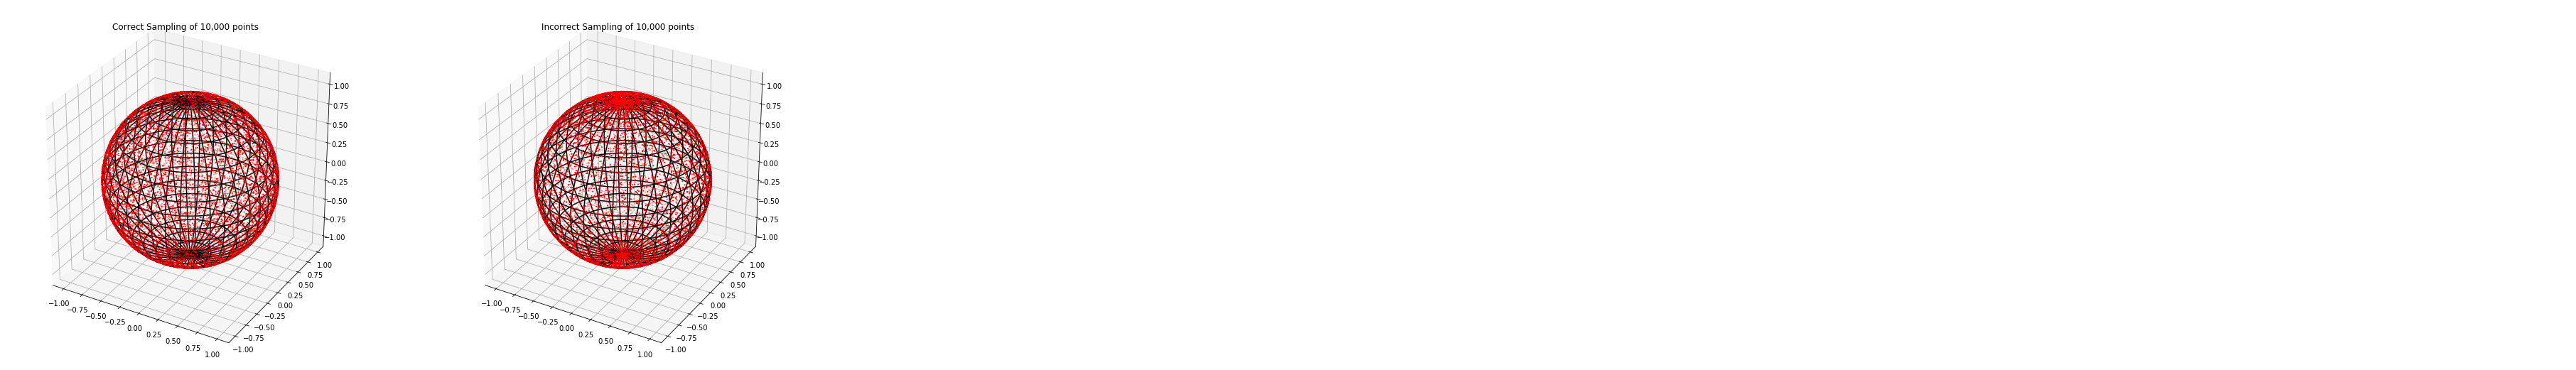

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

correct_thetas, correct_phis = sample_spherical(10000)
wrong_thetas, wrong_phis = wrong_sample_spherical(10000)

phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)
x = np.outer(np.sin(theta), np.cos(phi))
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))

correct_x = np.sin(correct_phis) * np.cos(correct_thetas)
correct_y = np.sin(correct_phis) * np.sin(correct_thetas)
correct_z = np.cos(correct_phis) * np.ones_like(correct_thetas)

wrong_x = np.sin(wrong_phis) * np.cos(wrong_thetas)
wrong_y = np.sin(wrong_phis) * np.sin(wrong_thetas)
wrong_z = np.cos(wrong_phis) * np.ones_like(wrong_thetas)

fig, ax = plt.subplots(1, 2, subplot_kw={'projection':'3d', 'aspect':'equal'}, figsize=(20,20))
ax[0].plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax[0].scatter(correct_x, correct_y, correct_z, s=1, c='r', zorder=1)
ax[0].set_title('Correct Sampling of 10,000 points')
ax[1].plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax[1].scatter(wrong_x, wrong_y, wrong_z, s=1, c='r', zorder=1)
ax[1].set_title('Incorrect Sampling of 10,000 points')
plt.show()

Next, we have to generate expansion coefficients $a_{nm}$ for the spherical harmonic decomposition of the spherical function that underlies our spherically symmetric real-valued function $f$.

In [30]:
def generate_coeffs(l):
    """Generate random expansion coefficients
    for the spherical harmonic decomposition
    up to l-th degree
    """
    coeffs = []
    # 0-th coefficient is 1.
    coeffs.append([1])
    for n in range(1, l+1):
        coeff = []
        for m in np.linspace(-n, n, 2*n + 1, dtype=int):
            # The rest of the coefficients are randomly
            # sampled from a standard normal distribution.
            coeff.append(np.random.randn())
        coeffs.append(coeff)
    return coeffs

# We generate coefficients up to 85th degree,
# since starting from 86, certain orders of the
# degree result in undefined coefficient values.
a_nm = generate_coeffs(85)

Now, we simulate the spherically symmetric real-valued function $f$ using the generated coefficients $a_{nm}$, the upper limit on the degree of the spherical harmonic decomposition $l$, and inputs $\theta$ and $\phi$. For that purpose, we use Kazhdan's rotation invariant descriptors, i.e., the energies of a spherical function $g$, $SH\left(g\right) = \left\{\left\|g_{0}\left(\theta, \phi\right)\right\|, \left\|g_{1}\left(\theta, \phi\right)\right\|, ...\right\}$ where $g_n$ are the frequency components of $g$:
$$g_{n}\left(\theta, \phi\right) = \pi_{n}\left(g\right) = \sum_{m \ = \ n}^{-n} a_{nm} Y_{n}^{m}\left(\theta, \phi\right).$$
In the equation above, $\pi_n$ is the projection onto the subspace $V_{n} = Span\left(Y_{n}^{-n},Y_{n}^{-n+1},...,Y_{n}^{n-1},Y_{n}^{n}\right)$, and $Y_{n}^{m}$ is the spherical harmonic of degree $n \geq 0$ and order $\left|m\right| \leq n$. To process the pattern $X$, we define $f_l$ to be:
$$f_l\left(X = \left(x_1, x_2, ..., x_{12}\right)\right) = \sum_{n \ = \ 0}^{l}\left\|\sum_{i \ = \ 1}^{12}x_i \cdot g_{n}\left(\theta_i, \phi_i\right)\right\|$$ where $\forall \ i: \ x_i \in \left\{0, 1\right\}$.

In [32]:
def func(a_nm, l, thetas, phis):
    """Apply f_l as defined above to the
    inputs thetas and phis using the
    decomposition coefficients a_nm
    """
    result = 0
    # the first summation
    for n in range(l+1):
        result_n = 0
        # the second summation
        for (theta, phi) in zip(thetas, phis):
            # the third summation corresponding to the freqency
            # component of the function
            for m in np.linspace(-n, n, 2*n + 1, dtype=int):
                result_n += a_nm[n][m] * sph_harm(m, n, theta, phi)
        # L2 norm
        result += np.linalg.norm(result_n)
    return result    

Now, we assume $f = f_{85}$ which implies that the expansion coefficients of the 86th degree and on are all zero. To find the appropriate $\theta$ value for $\Theta\left(f\left(X\right) - \theta\right)$, we look at our analysis of the provided data above. We see that the sum values between 0 and 4 involving the 12 binary inputs of $X$ correspond to $Y = 0$, and the sum values between 8 and 12 to $Y = 1$. We also see that roughly 57.58% of the data points corresponding to the sum value of 6 result in $Y = 1$. Hence, we assign the 42.42nd percentile (roughly 468.67) of $f_{85}(X_6)$ ($X_6$ corresponds to the data points with sum value of 6) to $\theta$. We get binary $\hat{Y}$ values through $\hat{Y} = \Theta\left(f_{85}\left(X\right) - 468.67\right)$. In the end, we calculate the share of $\hat{Y}=1$ per each value of the sum of the binary inputs of $X$. As you can see below, the resulting numbers roughly mirror the ones we got above using the provided data set.

In [33]:
X_sum_Y_hat = []

for i in range(13):
    X_sum_Y_hat.append([])

for i in range(len(X)):
    n_pos_inputs = np.sum(X[i])
    X_sum_Y_hat[n_pos_inputs].append(func(a_nm, 85, thetas[X[i].astype(bool)], phis[X[i].astype(bool)]))

threshold = np.percentile(X_sum_Y_hat[6], 42.42)
print('\u03B8 \u2248 ' + str(np.around(threshold, decimals = 2)))

print('')
        
print('Share of \u0398(f(X)-\u03B8)=1 per each value of the sum of the binary inputs of X:')
for i in range(13):
    proportion = 100 * np.sum(np.array(X_sum_Y_hat[i]) > threshold)/len(X_sum_Y_hat[i])
    print(f'{i}: {proportion}%')

θ ≈ 468.67

Share of Θ(f(X)-θ)=1 per each value of the sum of the binary inputs of X:
0: 0.0%
1: 0.0%
2: 0.0%
3: 0.0%
4: 0.0%
5: 9.848484848484848%
6: 57.57575757575758%
7: 96.08585858585859%
8: 100.0%
9: 100.0%
10: 100.0%
11: 100.0%
12: 100.0%


In the next step, we soften $\hat{Y} = \Theta\left(f\left(X\right) - \theta\right)$ to $p\left(\hat{Y}=1\ \ | \ X \right) = \psi\left(f\left(X\right) - \theta\right)$ where $\psi\left(u\right) = \frac{1}{1+e^{-\gamma \cdot u}}$. Here, $\gamma$ is the sigmoidal gain and it should be high enough to keep the mutual information $I\left(X \ ; \ \hat{Y}\right) \approx 0.99$ bits. We set $\gamma$ to 1. We also assume that the selected $\theta \approx 468.67$ results in $p\left(\hat{Y}=1\right)=\sum_{X}p\left(\hat{Y}=1 \ | \ X \right) \cdot p\left(X\right) \approx 0.5$ with uniform $p\left(X\right)$. As you can see below, the values we get for $I\left(X \ ; \ \hat{Y}\right)$ and $p\left(\hat{Y}=1\right)$ do meet the requirements.

In [ ]:
def sigmoidal_func(u, gamma=1):
    """Sigmoidal function with
    the sigmoidal gain gamma
    """
    return 1/(1 + np.exp(-gamma*u))

# Here we calculate p(Y^hat = 1)
p_Y_hat = 0
p_X = 1/4096
for i in range(13):
    p_Y_hat += np.sum(sigmoidal_func(np.array(X_sum_Y_hat[i]) - threshold))
p_Y_hat *= p_X
print('p(\u0176=1) \u2248 ' + str(np.around(p_Y_hat, decimals = 1)))

# Here we calculate H(Y^hat)
H_Y_hat = -p_Y_hat*np.log2(p_Y_hat)-(1-p_Y_hat)*np.log2(1-p_Y_hat)
print('H(\u0176) \u2248 ' + str(np.around(H_Y_hat, decimals = 2)))

# Here we calculate H(Y^hat|X)
H_Y_hat_given_X = 0
p_X = 1/4096
for i in range(13):
    p_Y_hat_given_X = sigmoidal_func(np.array(X_sum_Y_hat[i]) - threshold)
    H_Y_hat_given_X -= np.sum(p_Y_hat_given_X*np.log2(p_Y_hat_given_X))
H_Y_hat_given_X *= p_X
print('H(\u0176|X) \u2248 ' + str(np.around(H_Y_hat_given_X, decimals = 2)))

# Here we calculate I(X;Y^hat) = H(Y^hat) - H(Y^hat|X)
I_X_Y_hat = H_Y_hat - H_Y_hat_given_X
print('I(X;\u0176) = H(\u0176) - H(\u0176|X) \u2248 '
      + str(np.around(H_Y_hat, decimals = 2)) + ' - '
      + str(np.around(H_Y_hat_given_X, decimals = 2)) + ' = '
      + str(np.around(I_X_Y_hat, decimals = 2)))